In [1]:
import numpy as np
import pandas as pd

# **Loading the Data**

## *In this section, the dataset is loaded from a CSV file, and specific columns are selected for further analysis:*
### This code reads a CSV file containing Google Play Store app data and selects the columns 'App Name', 'Rating Count', 'Rating', 'Installs', and 'Price' for analysis.

In [2]:
df = pd.read_csv("/kaggle/input/google-playstore-apps/Google-Playstore.csv")

df = df[['App Name', 'Rating Count', 'Rating', 'Installs', 'Price']]

df.isnull().sum()

App Name            5
Rating Count    22883
Rating          22883
Installs          107
Price               0
dtype: int64

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   App Name      object 
 1   Rating Count  float64
 2   Rating        float64
 3   Installs      object 
 4   Price         float64
dtypes: float64(3), object(2)
memory usage: 88.2+ MB


In [4]:
df["Installs"].head()

0       10+
1    5,000+
2       50+
3       10+
4      100+
Name: Installs, dtype: object

# **Handling Missing Values**

## *Here, missing values are identified and handled:*
### Missing values are first checked using isnull(). In the 'Installs' column, empty strings and non-numeric values (e.g., 'None', 'NaN') are replaced with NaN. Then, rows with missing 'Installs' values are dropped.

In [5]:
df['Installs'] = df['Installs'].replace(['None', 'NaN', '', ' '], np.nan)
df = df.dropna(subset=['Installs'])
print(df["Installs"].isna().sum())

0


# **Data Cleaning**

## *This section handles cleaning and formatting the 'Installs' column:*

In [6]:
df['Installs'] = df['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
df['Installs'].head()

0      10
1    5000
2      50
3      10
4     100
Name: Installs, dtype: int64

# **Handling Missing Ratings**

## *Filling missing values for 'Rating' and 'Rating Count':*

In [7]:
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Rating Count'] = df['Rating Count'].fillna(df['Rating Count'].mean())
df.isna().sum()

App Name        5
Rating Count    0
Rating          0
Installs        0
Price           0
dtype: int64

# **Feature Scaling**

## *Standard scaling is applied to the numerical columns:*

### The numerical columns ('Rating', 'Rating Count', 'Installs', 'Price') are scaled using StandardScaler, which standardizes the features by removing the mean and scaling to unit variance.

In [8]:
numeric_columns = ['Rating', 'Rating Count', 'Installs', 'Price']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df[numeric_columns])

X_scaled = X_scaled.astype(np.float32)

# **DBSCAN Clustering and Chunking the Data**

### The DBSCAN clustering algorithm is defined to identify clusters in the data, with eps=0.5 as the neighborhood radius and min_samples=5 as the minimum number of samples required to form a cluster.

### The dataset is divided into smaller chunks of 10,000 rows each to handle memory efficiently. DBSCAN is applied to each chunk, and the resulting labels (clusters) are combined.

In [9]:
from sklearn.cluster import DBSCAN


def process_chunk(X_chunk):
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    return dbscan.fit_predict(X_chunk)

chunk_size = 10000
chunks = [X_scaled[i:i + chunk_size] for i in range(0, X_scaled.shape[0], chunk_size)]

labels = np.concatenate([process_chunk(chunk) for chunk in chunks])

df['Cluster'] = labels
df['Anomaly'] = df['Cluster'] == -1


# **Identifying Anomalies**

### Clusters and anomalies are added to the original dataframe. In DBSCAN, points labeled -1 are considered anomalies. The code counts and prints the anomalies.

In [10]:
anomalies = df[df['Anomaly']]
print(f"Anomali sayısı: {len(anomalies)}")

print(anomalies[['App Name', 'Rating', 'Rating Count', 'Installs', 'Price']].head())


Anomali sayısı: 6405
                                               App Name  Rating  Rating Count  \
786                                       K8 CODE PRIME     0.0           0.0   
1313  Screen Recorder, Video Recorder, V Recorder Ed...     4.6     1264773.0   
1401                                       Sub Rosa Pro     2.0          69.0   
2157                      Essentials of Paediatrics, 2e     0.0           0.0   
3007                    AntiVirus Android Security 2021     4.1         181.0   

       Installs  Price  
786          10  24.99  
1313  100000000   0.00  
1401       1000  99.99  
2157          1  41.99  
3007       1000  19.99  


# **Dimensionality Reduction and Visualization**

###  PCA (Principal Component Analysis) reduces the data to two dimensions for visualization. Clusters are shown in different colors, and anomalies are highlighted in red.

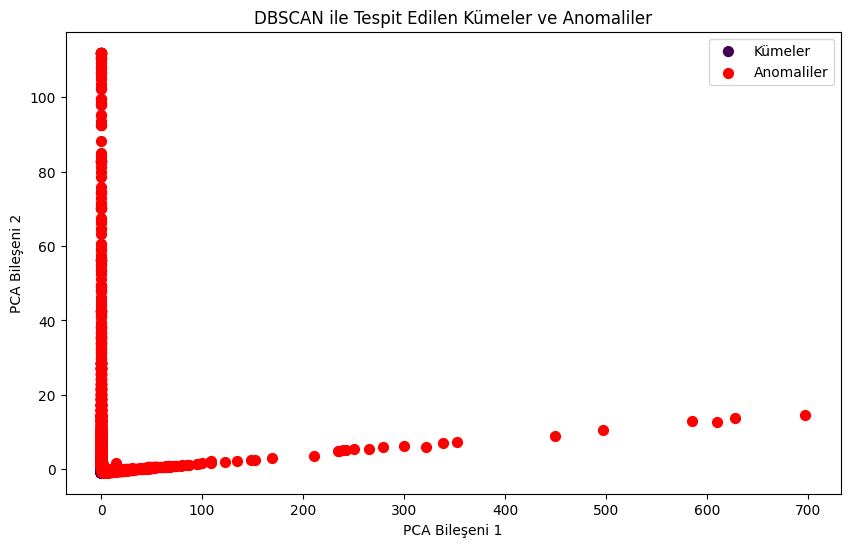

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df['Cluster'] != -1, 0], X_pca[df['Cluster'] != -1, 1], 
            c=df['Cluster'][df['Cluster'] != -1], cmap='viridis', s=50, label='Kümeler')
plt.scatter(X_pca[df['Cluster'] == -1, 0], X_pca[df['Cluster'] == -1, 1], 
            c='red', s=50, label='Anomaliler')
plt.title('DBSCAN ile Tespit Edilen Kümeler ve Anomaliler')
plt.xlabel('PCA Bileşeni 1')
plt.ylabel('PCA Bileşeni 2')
plt.legend()
plt.show()


# **Davies-Bouldin Index**

### The Davies-Bouldin Index returns a score by considering the distance between clusters and the compactness of each cluster.

In [13]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X_scaled, labels)
print(f"Davies-Bouldin Skoru: {db_score}")


Davies-Bouldin Skoru: 12.782790832582085


### Importing libraries

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


### Importing the dataset with pandas

In [15]:
data = pd.read_csv('../input/google-playstore-apps/Google-Playstore.csv')
data.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


## Data exploration and cleaning

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

In [20]:
data.isna().sum()

App Name                  5
App Id                    0
Category                  0
Rating                22883
Rating Count          22883
Installs                107
Minimum Installs        107
Maximum Installs          0
Free                      0
Price                     0
Currency                135
Size                    196
Minimum Android        6530
Developer Id             33
Developer Website    760835
Developer Email          31
Released              71053
Last Updated              0
Content Rating            0
Privacy Policy       420953
Ad Supported              0
In App Purchases          0
Editors Choice            0
Scraped Time              0
dtype: int64

### For this analysis I'm going to use these columns; Category, Rating, Rating Count, Installs, Free, Last Updated.

As we can see; rating, rating count columns have moderately higher missing values than other columns that we are going to use. So let us clean these columns and start explore our data with visualization.

In [21]:
data['Rating'] = data['Rating'].fillna(data['Rating'].mean())
data['Rating Count'] = data['Rating Count'].fillna(data['Rating Count'].mean())
data['Installs'].dropna(inplace=True)

#Setting last updated column as datetime
data['Last Updated'] = pd.to_datetime(data['Last Updated'])
#Subtracting last update date from today's date to create days since last update column
data['Days since last update'] = (pd.Timestamp('today') - data['Last Updated']).dt.days

new_data = data[['Rating', 'Rating Count', 'Installs', 'Category', 'Free', 'Last Updated','Days since last update']]
new_data.isna().sum()


Rating                      0
Rating Count                0
Installs                  107
Category                    0
Free                        0
Last Updated                0
Days since last update      0
dtype: int64

In [26]:
#There could be string formatted None, NaN values or maybe there could be empty strings so we gotta change these values to proper nans
new_data['Installs'] = new_data['Installs'].replace(['None', 'NaN', '', ' '], np.nan)
new_data = new_data.dropna(subset=['Installs'])
print(new_data["Installs"].isna().sum())

/tmp/ipykernel_1710/761459836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Installs'] = new_data['Installs'].replace(['None', 'NaN', '', ' '], np.nan)


0


In [27]:
#Now we can format Installs as int
new_data['Installs'] = new_data['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
new_data['Installs'].head()

0      10
1    5000
2      50
3      10
4     100
Name: Installs, dtype: int64

## Visualizations

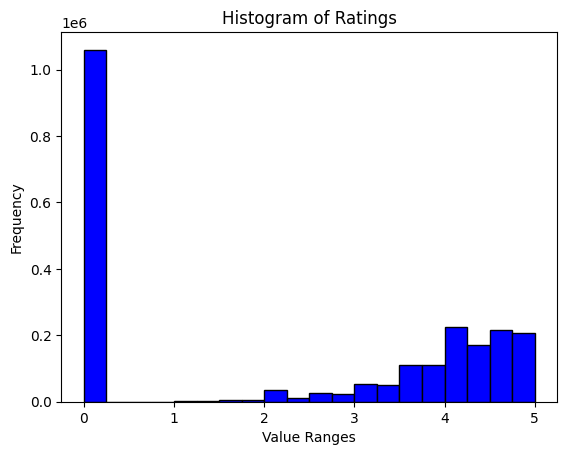

In [28]:
plt.hist(new_data['Rating'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Ratings')
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')
plt.show()

#### There are so many 0 values but i am going to keep them since this is a churn analysis

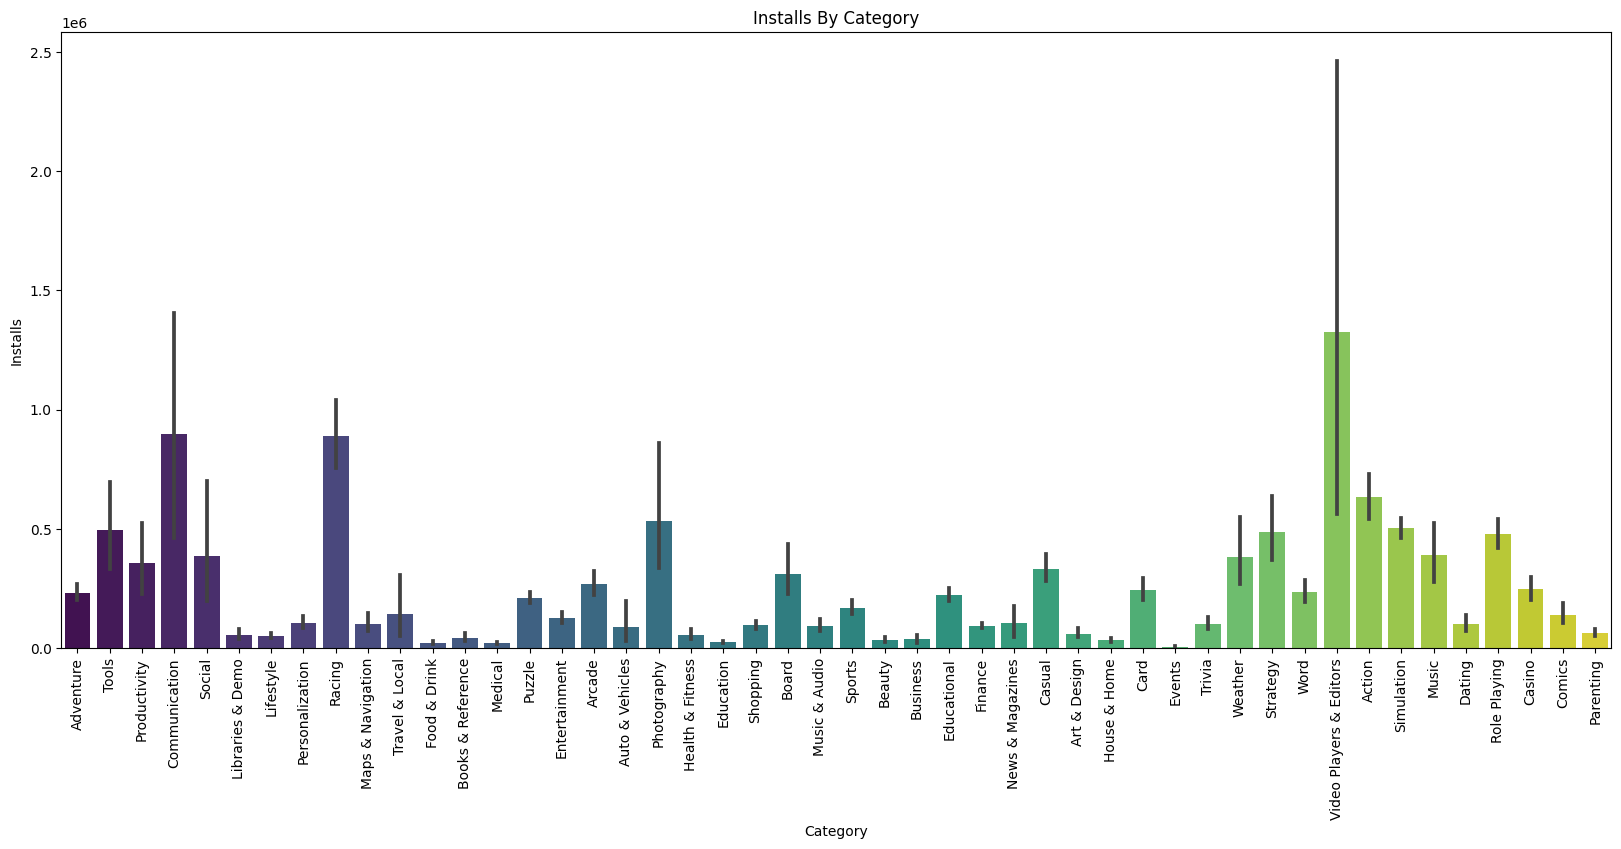

In [29]:
plt.figure(figsize=(20, 8))
sns.barplot(x='Category', y='Installs', data=new_data, palette='viridis')

plt.title('Installs By Category')
plt.xlabel('Category')
plt.ylabel('Installs')
plt.xticks(rotation=90)
plt.show()

In [35]:
category_counts = new_data.groupby(['Category', 'Free']).size().reset_index(name='Count')

fig = px.bar(category_counts, 
             x='Category', 
             y='Count', 
             color='Free', 
             barmode='group', 
             title='Number of Free and Paid Apps by Category')

fig.update_layout(xaxis={'categoryorder':'total descending'}, 
                  xaxis_tickangle=-45)
fig.show()

In [36]:
category_ratings = new_data.groupby(['Category', 'Free'])['Rating'].mean().reset_index()

fig = px.bar(category_ratings, 
             x='Category', 
             y='Rating', 
             color='Free', 
             barmode='group', 
             title='Average Rating of Free and Paid Apps by Category',
             labels={'Rating':'Average Rating', 'Free':'Free (True = Free, False = Paid)'})

fig.update_layout(xaxis_tickangle=-45)
fig.update_yaxes(range=[1, 5])
fig.show()

## Building Model

In [37]:
#Added Churn column for analysis
def complex_churn_model(row):
    if row['Rating'] <= 2 and row['Rating Count'] < 1000 and row['Days since last update'] > 365:
        return 1  # Churn
    else:
        return 0  # Not Churn
    
new_data['Churn'] = new_data.apply(complex_churn_model, axis=1)
new_data.head()

,Rating,Rating Count,Installs,Category,Free,Last Updated,Days since last update,Churn
0,0.0,0.0,10,Adventure,True,2020-02-26,1667,1
1,4.4,64.0,5000,Tools,True,2021-05-06,1232,0
2,0.0,0.0,50,Productivity,True,2019-08-19,1858,1
3,5.0,5.0,10,Communication,True,2018-10-13,2168,0
4,0.0,0.0,100,Tools,True,2018-11-12,2138,1


In [38]:
#Formatting Category values as numeric
label_encoder = LabelEncoder()
new_data['Category'] = label_encoder.fit_transform(new_data['Category'])

### Train, test split

In [39]:
X = new_data[['Category', 'Rating', 'Rating Count', 'Installs', 'Free','Days since last update']]
y = new_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
model = LogisticRegression()

### Getting the greater results with random search

In [41]:
param_dist = {
    'C': uniform(loc=0, scale=4),  
    'solver': ['liblinear', 'lbfgs'],  
    'penalty': ['l2'],  
    'max_iter': np.arange(100, 500, 100) 
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Parameters: {'C': 3.8625281322982374, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
y_pred = random_search.best_estimator_.predict(X_test)

### Evaluation of model

In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

In [ ]:
#Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.title('Confusion matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.show()